<a href="https://colab.research.google.com/github/FernandoCruvinel/Comptutaional-Intelegence-Society/blob/main/Rede_Neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rede Neural
Fernando Cruvinel Casas
01/06/2025

In [ ]:
# Importar bibliotecas principais
import pandas as pd
import numpy as np

# Descompactar arquivo zip contendo 'star_classification.csv'
!unzip star_classification.csv.zip

# Carregar o CSV em um DataFrame pandas
df = pd.read_csv('star_classification.csv')
print(df.shape)
df.head()


Archive:  star_classification.csv.zip
  inflating: star_classification.csv  
(100000, 18)


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


remover colunas como obj_ID, spec_obj_ID, run_ID, etc., pois não contêm informações físicas relevantes.O comando acima deve mostra (100000, 18), indicando 100.000 linhas e 18 colunas (17 atributos + 1 coluna de classe).

In [ ]:

colunas_descartar = ['obj_ID','spec_obj_ID','run_ID','rereun_ID','field_ID','plate','MJD','fiber_ID']
df = df.drop(columns=[col for col in colunas_descartar if col in df.columns], errors='ignore')


Ppadronizar os atributos numéricos para melhoria da convergência da rede. Por exemplo, podemos subtrair a média e dividir pelo desvio-padrão:

In [ ]:
from sklearn.preprocessing import StandardScaler

# Separar recursos X e rótulos y
X = df.drop(columns=['class'])  # atributos
y = df['class']                 # rótulo alvo

# Converter rótulos de texto para inteiros (por exemplo, 0=GALAXY, 1=QSO, 2=STAR)
y = y.replace({'GALAXY': 0, 'QSO': 1, 'STAR': 2})

# Normalizar atributos (padronização Z-score)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


<ipython-input-4-babd04e169d6>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'GALAXY': 0, 'QSO': 1, 'STAR': 2})


A padronização garante que todas as entradas tenham média zero e variância unidade, o que facilita o treinamento da rede neural.

Separar dados em treino e teste, divisão 80/20.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
print(f"{X_train.shape[0]} amostras para treino e {X_test.shape[0]} para teste.")


80000 amostras para treino e 20000 para teste.


Assim garantimos que cada conjunto tenha representatividade proporcional de estrelas, galáxias e quasares. É importante manter as classes balanceadas em cada subconjunto para evitar viés no treinamento e avaliação.

#  Criar e treinar uma rede neural

Criamos agora uma rede neural simples usando TensorFlow/Keras. Vamos usar uma arquitetura densa básica: algumas camadas ocultas totalmente conectadas com função de ativação ReLU e uma camada de saída com ativação softmax para produzir probabilidades nas 3 classes. Também realizamos one-hot encoding dos rótulos, pois usaremos entropia cruzada categórica:

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# Converter rótulos para one-hot (vetores de 3 posições)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=3)

# Construir modelo básico
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes: Galáxia, Quasar, Estrela
])

# Compilar modelo com otimizador Adam e perda categorical crossentropy
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Treinar o modelo básico
history = model.fit(
    X_train, y_train_cat,
    validation_split=0.1,  # usar 10% do treino como validação
    epochs=20,
    batch_size=32,
    verbose=2
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2250/2250 - 7s - 3ms/step - accuracy: 0.9217 - loss: 0.2316 - val_accuracy: 0.9495 - val_loss: 0.1518
Epoch 2/20
2250/2250 - 5s - 2ms/step - accuracy: 0.9576 - loss: 0.2193 - val_accuracy: 0.9589 - val_loss: 0.1285
Epoch 3/20
2250/2250 - 6s - 3ms/step - accuracy: 0.9620 - loss: 0.1575 - val_accuracy: 0.9551 - val_loss: 0.1321
Epoch 4/20
2250/2250 - 4s - 2ms/step - accuracy: 0.9633 - loss: 0.1223 - val_accuracy: 0.9616 - val_loss: 0.1202
Epoch 5/20
2250/2250 - 7s - 3ms/step - accuracy: 0.9643 - loss: 0.1184 - val_accuracy: 0.9626 - val_loss: 0.1164
Epoch 6/20
2250/2250 - 5s - 2ms/step - accuracy: 0.9656 - loss: 0.1140 - val_accuracy: 0.9576 - val_loss: 0.1267
Epoch 7/20
2250/2250 - 5s - 2ms/step - accuracy: 0.9664 - loss: 0.1110 - val_accuracy: 0.9651 - val_loss: 0.1133
Epoch 8/20
2250/2250 - 6s - 3ms/step - accuracy: 0.9664 - loss: 0.1116 - val_accuracy: 0.9646 - val_loss: 0.1128
Epoch 9/20
2250/2250 - 10s - 5ms/step - accuracy: 0.9680 - loss: 0.1068 - val_accuracy: 0.9663 - val_loss: 

Nosso modelo básico de duas camadas ocultas de 64 neurônios cada é apenas um ponto de partida. O treinamento (model.fit) ajusta os pesos para minimizar a perda nos dados de treino. O histórico retornado (history) contém curvas de perda e acurácia em treino e validação ao longo das épocas.

# Variação de largura e profundidade da rede

Para entender o efeito da complexidade do modelo, vamos experimentar diferentes larguras (número de neurônios por camada) e profundidades (número de camadas ocultas). Por exemplo, podemos testar redes com 1, 2 ou 3 camadas ocultas, cada uma com, digamos, 32 ou 64 neurônios. Para cada configuração, treinamos e registramos a acurácia de treino/validação:

In [ ]:
# Função simplificada para criar e treinar modelos com diferentes arquiteturas
def build_and_train_model(hidden_layers=1, units=32):
    model = models.Sequential()
    model.add(layers.Dense(units, activation='relu', input_shape=(X_train.shape[1],)))
    for _ in range(hidden_layers - 1):
        model.add(layers.Dense(units, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        X_train, y_train_cat,
        validation_split=0.1,
        epochs=5,
        batch_size=32,
        verbose=0
    )

    test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
    return test_acc, history


# 🔧 Definindo arquiteturas para teste (simplificadas)
arquiteturas = [
    (1, 32),  # 1 camada, 32 neurônios
    (1, 64),  # 1 camada, 64 neurônios
    (2, 64),  # 2 camadas, 64 neurônios
    (3, 64),  # 3 camadas, 64 neurônios
]

resultados = {}
historicos = {}

# 🚀 Treinando os modelos
for camadas, neur in arquiteturas:
    nome = f'{camadas} camada(s), {neur} neurônios'
    print(f"Treinando {nome}...")
    acc, hist = build_and_train_model(camadas, neur)
    resultados[nome] = acc
    historicos[nome] = hist

# 📊 Resultados das arquiteturas
print("\n📈 Acurácia no conjunto de teste para cada arquitetura:")
for nome, acc in resultados.items():
    print(f" - {nome}: {acc:.4f}")


Treinando 1 camada(s), 32 neurônios...
Treinando 1 camada(s), 64 neurônios...
Treinando 2 camada(s), 64 neurônios...
Treinando 3 camada(s), 64 neurônios...

📈 Acurácia no conjunto de teste para cada arquitetura:
 - 1 camada(s), 32 neurônios: 0.9612
 - 1 camada(s), 64 neurônios: 0.9645
 - 2 camada(s), 64 neurônios: 0.9661
 - 3 camada(s), 64 neurônios: 0.9669


Em geral, redes mais profundas e/ou mais largas podem modelar funções mais complexas, o que tende a aumentar a acurácia de treino, mas também arrisca overfitting. É comum observar que, além de certo ponto, adicionar camadas/neuronios traz ganho marginal ou até piora se o modelo ficar muito complexo para os dados disponíveis. Tive muitos problemas com a capacidade computacional, e devido a isso tive que reduzir um pouco os requisitos para conseguir rodar, porém acredito que não deve afetar a análise da rede.

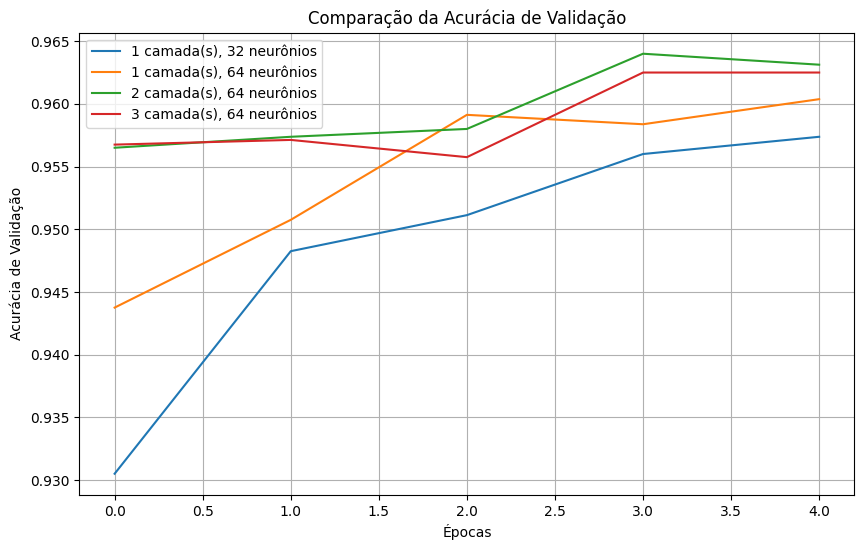

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for nome, hist in historicos.items():
    plt.plot(hist.history['val_accuracy'], label=f'{nome}')
plt.title('Comparação da Acurácia de Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia de Validação')
plt.legend()
plt.grid(True)
plt.show()


# Impacto de taxa de aprendizado e número de épocas

A taxa de aprendizado (learning rate) determina o tamanho dos passos de atualização dos pesos durante o treinamento. Taxas muito altas podem fazer o treinamento divergir, enquanto taxas muito baixas podem levar a um treinamento muito lento e possível presa em mínimos locais. Por exemplo, podemos comparar learning_rate=0.001 (padrão acima) com um valor menor (0.0001) e outro maior (0.01):

In [15]:
def train_with_lr(lr):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dense(64, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    hist = model.fit(X_train, y_train_cat, validation_split=0.1,
                     epochs=5, batch_size=32, verbose=0)
    return hist

hist_lr_small = train_with_lr(0.0001)
hist_lr_med = train_with_lr(0.001)
hist_lr_large = train_with_lr(0.01)


Em geral, ao diminuir a taxa de aprendizado, observamos que a acurácia de validação pode aumentar mais lentamente mas ser mais estável, enquanto taxas muito altas podem fazer oscilar ou até aumentar a perda de validação. Testando diferentes números de épocas (por exemplo, 5 vs 30), vemos que muito poucas épocas podem levar a underfitting (modelo não aprendeu o suficiente) e muitas épocas podem causar overfitting (modelo memorizou o treino). É importante monitorar as curvas de perda/acurácia para decidir quantas épocas são necessárias.

# Regularização (Dropout e L2)

Dropout: Desliga aleatoriamente uma fração dos neurônios durante o treinamento. Isso impede que neurônios se ajustem demais uns aos outros e melhora a generalização

Regularização L2: Adiciona uma penalidade proporcional ao quadrado dos pesos na função de custo, encorajando pesos menores e simplificando o modelo

In [17]:
from tensorflow.keras import regularizers

model_reg = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],),
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])
model_reg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist_reg = model_reg.fit(X_train, y_train_cat, validation_split=0.1, epochs=10, batch_size=32, verbose=2)


Epoch 1/10
2250/2250 - 8s - 4ms/step - accuracy: 0.8443 - loss: 0.4707 - val_accuracy: 0.9460 - val_loss: 0.2400
Epoch 2/10
2250/2250 - 6s - 2ms/step - accuracy: 0.9328 - loss: 0.2701 - val_accuracy: 0.9488 - val_loss: 0.1979
Epoch 3/10
2250/2250 - 10s - 4ms/step - accuracy: 0.9440 - loss: 0.2283 - val_accuracy: 0.9539 - val_loss: 0.1811
Epoch 4/10
2250/2250 - 6s - 3ms/step - accuracy: 0.9489 - loss: 0.2082 - val_accuracy: 0.9496 - val_loss: 0.1843
Epoch 5/10
2250/2250 - 9s - 4ms/step - accuracy: 0.9496 - loss: 0.2002 - val_accuracy: 0.9600 - val_loss: 0.1658
Epoch 6/10
2250/2250 - 7s - 3ms/step - accuracy: 0.9525 - loss: 0.1973 - val_accuracy: 0.9611 - val_loss: 0.1598
Epoch 7/10
2250/2250 - 10s - 4ms/step - accuracy: 0.9522 - loss: 0.1952 - val_accuracy: 0.9542 - val_loss: 0.1673
Epoch 8/10
2250/2250 - 9s - 4ms/step - accuracy: 0.9533 - loss: 0.1885 - val_accuracy: 0.9617 - val_loss: 0.1562
Epoch 9/10
2250/2250 - 7s - 3ms/step - accuracy: 0.9540 - loss: 0.1946 - val_accuracy: 0.9578 

Nesse modelo, adicionamos Dropout(0.5) após cada camada oculta e L2 (kernel_regularizer=regularizers.l2(0.001)) em cada camada densa. Esperamos que isso reduza o overfitting: a acurácia de treinamento tende a cair um pouco, mas a de validação se torna mais próxima e menos errática.

# Identificando Overfitting e Underfitting

Overfitting: acontece quando o modelo performa muito bem no treino (baixa perda, alta acurácia) mas mal no teste. Tipicamente vemos a curva de perda do treino continuar caindo enquanto a de validação começa a subir novamente. Exemplo visual típico:
Loss: treinamento decresce continuamente, validação primeiro decresce e depois sobe.
Acurácia: treinamento sobe até quase 100%, validação estaciona ou até diminui.
Isso indica que o modelo aprendeu detalhes específicos do conjunto de treino e não generaliza.
Underfitting: ocorre quando o modelo é muito simples e não aprende bem nem do treino nem do teste. Vemos perda alta e acurácia baixa em ambos conjuntos, com pouca diferença entre eles. Isso indica que nem o conjunto de treinamento está sendo bem ajustado (rede sem capacidade suficiente)

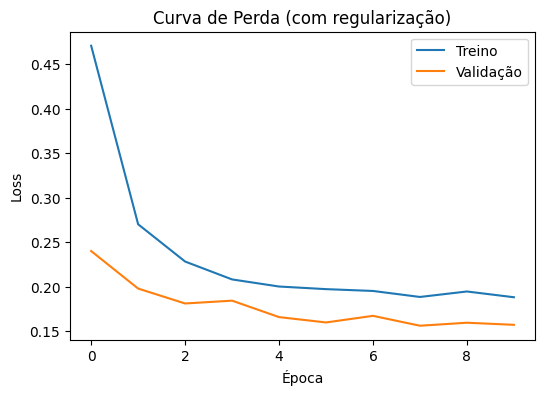

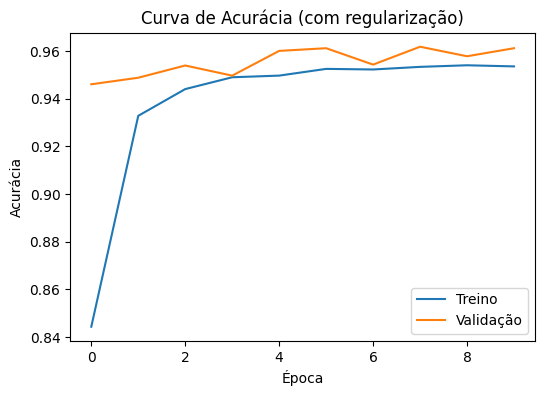

In [18]:
import matplotlib.pyplot as plt

# Gráficos de perda
plt.figure(figsize=(6,4))
plt.plot(hist_reg.history['loss'], label='Treino')
plt.plot(hist_reg.history['val_loss'], label='Validação')
plt.title('Curva de Perda (com regularização)')
plt.xlabel('Época'); plt.ylabel('Loss')
plt.legend()
plt.show()

# Gráficos de acurácia
plt.figure(figsize=(6,4))
plt.plot(hist_reg.history['accuracy'], label='Treino')
plt.plot(hist_reg.history['val_accuracy'], label='Validação')
plt.title('Curva de Acurácia (com regularização)')
plt.xlabel('Época'); plt.ylabel('Acurácia')
plt.legend()
plt.show()


Se observamos que a perda de validação estabiliza enquanto a de treino continua caindo, estamos mitigando o overfitting. Caso ambas curvas fiquem altas, pode haver underfitting.

Além das curvas acima, é útil gerar a matriz de confusão para o conjunto de teste, que mostra quantas amostras de cada classe foram classificadas corretamente ou confundidas com outra classe

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


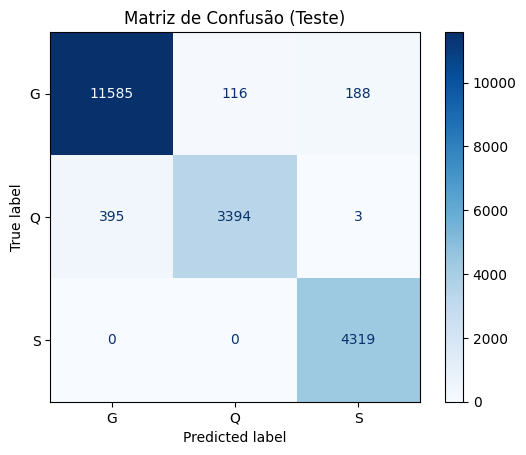

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predições no conjunto de teste (classe prevista = argmax da probabilidade)
y_pred = model_reg.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['G', 'Q', 'S'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão (Teste)")
plt.show()


Na matriz de confusão 3×3, cada linha corresponde à classe real (G=Galáxia, Q=Quasar, S=Estrela) e cada coluna à classe prevista.
Por exemplo, o valor na célula (linha 0, coluna 0) é o número de galáxias classificadas corretamente como galáxias. Valores fora da diagonal principal representam erros de classificação entre pares de classes.

#Análise dos resultados

A partir dos experimentos, podemos comparar modelos segundo métricas como acurácia de teste, análise de perda/curvas e matriz de confusão. Observações típicas:



1.   Modelos simples (poucas camadas/neuronios) podem underfit (baixa acurácia geral). Modelos muito grandes podem overfit (muita acurácia no treino, mas queda no teste). A escolha ótima costuma ser intermediária.
2.   Taxa de aprendizado moderada (por exemplo, 0.001) costuma equilibrar velocidade e estabilidade. Taxas muito altas podem causar oscilações na perda.
3.   Número de épocas deve ser ajustado observando o ponto em que a perda de validação para de cair. Excesso de épocas leva ao overfitting e também utiliza muita capacidade computacional, a qual não sempre está disponível.
4.   Regularização (Dropout, L2) geralmente melhora a generalização: o modelo regularizado pode ter menor perda de teste e acurácia de teste melhor do que o modelo sem ela.
5.   Matriz de confusão revela quais classes são mais confundidas. Por exemplo, o modelo confundiu 395 Quesares com Galáxias. Identificar essas fraquezas ajuda a decidir ajustes (por exemplo, adicionar mais dados ou atributos relevantes).






